In [1]:
!pip install boto3 s3fs pandas
import boto3
import json
import io
import pandas as pd
import numpy as np
import re
import traceback
from typing import List, Dict, Any, Union
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


  Using cached s3fs-2025.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached aiobotocore-2.19.0-py3-none-any.whl.metadata (23 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached aioitertools-0.12.0-py3-none-any.whl.metadata (3.8 kB)
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
  Using cached aiobotocore-2.18.0-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.17.0-py3-none-any.whl.metadata (23 kB)
  Using cached botocore-1.35.93-py3-none-any.whl.metadata (5.7 kB)
Using cached s3fs-2025.2.0-py3-none-any.whl (30 kB)
Using cached fsspec-2025.2.0-py3-none-any.whl (184 kB)
Using cached aiobotocore-2.17.0-py3-none-any.whl (77 kB)
Using cached botocore-1.35.93-py3-none-any.whl (13.3 MB)
Using cached aioitertools-0.12.0-py3-none-any.whl (24 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec

In [2]:
# Notebook cell 1: Configure your S3 details and experiment name

S3_BUCKET = "bam-volatility-project"          # or your actual S3 bucket
EXPERIMENT_NAME = "experiment_20250127_1457_993f585e"
BASE_PATH = f"experiments/{EXPERIMENT_NAME}/runs"  # Typically "experiments/<exp_name>/runs"

# Create a boto3 client/resource
s3_client = boto3.client("s3")

# Helper: list all "directories" (or prefixes) under the experiment runs folder
# Each run should have a run_id folder in the path: s3://bucket/experiments/<exp_name>/runs/<run_id>/


In [3]:
def list_run_ids(bucket: str, base_path: str) -> List[str]:
    """
    Return a list of run_id prefixes under the given S3 base path.
    Each run_id typically looks like 'alex_seq_mlp_20250127_1205' or similar.
    """
    # We assume each run is stored under s3://bucket/base_path/<run_id>/
    # We'll list objects with the base_path prefix, then parse out run_id from the keys.
    
    # The 'Delimiter' param is not always reliable, so we might parse common prefixes ourselves.
    paginator = s3_client.get_paginator('list_objects_v2')
    result_iterator = paginator.paginate(Bucket=bucket, Prefix=base_path)
    
    run_ids = set()
    for page in result_iterator:
        # Each page has 'Contents' listing the keys
        for obj in page.get('Contents', []):
            key = obj['Key']  # e.g. "experiments/<exp_name>/runs/alex_seq_mlp_20250127_1205/config/args.json"
            # Extract the part right after base_path. Typically: runs/<run_id>/...
            suffix = key[len(base_path):].lstrip("/")
            # This might look like "<run_id>/config/args.json"
            # The run_id is the first path component
            parts = suffix.split("/")
            if len(parts) > 1:  # There's at least "<run_id>/something"
                run_ids.add(parts[0])
                
    return sorted(list(run_ids))


In [4]:
def read_s3_json(bucket: str, key: str) -> Union[Dict, List, None]:
    """
    Read a JSON file from S3. 
    Return the parsed dict/list or None if unable to read/parse.
    """
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
        raw_data = response['Body'].read()
        return json.loads(raw_data)
    except Exception as e:
        print(f"[WARN] Could not read or parse JSON from s3://{bucket}/{key} -> {e}")
        return None


In [5]:
def load_metrics_for_run(bucket: str, base_path: str, run_id: str) -> Dict[str, Any]:
    """
    Load metrics and config for a single run from S3.
    Returns a dictionary with:
      {
        "run_id": <string>,
        "epoch_metrics": pd.DataFrame or None,
        "batch_metrics": pd.DataFrame or None,
        "final_metrics": dict or None,
        "config": dict of config files or None,
        ...
      }
    We'll handle partial or missing data gracefully.
    """
    run_prefix = f"{base_path}/{run_id}"
    
    # Prepare output
    run_data = {
        "run_id": run_id,
        "epoch_metrics": None,
        "batch_metrics": None,
        "final_metrics": None,
        "config": {},
    }
    
    # 1) Load epoch_metrics.json
    epoch_metrics_key = f"{run_prefix}/metrics/epoch_metrics.json"
    epoch_json = read_s3_json(bucket, epoch_metrics_key)
    if isinstance(epoch_json, list):
        # Convert to DataFrame
        try:
            df_epoch = pd.DataFrame(epoch_json)
            run_data["epoch_metrics"] = df_epoch
        except Exception as e:
            print(f"[WARN] Could not convert epoch_metrics.json to DataFrame for run {run_id} -> {e}")
    
    # 2) Load batch_metrics.json
    batch_metrics_key = f"{run_prefix}/metrics/batch_metrics.json"
    batch_json = read_s3_json(bucket, batch_metrics_key)
    if isinstance(batch_json, list):
        try:
            df_batch = pd.DataFrame(batch_json)
            run_data["batch_metrics"] = df_batch
        except Exception as e:
            print(f"[WARN] Could not convert batch_metrics.json to DataFrame for run {run_id} -> {e}")
    
    # 3) Load final_metrics.json
    final_metrics_key = f"{run_prefix}/metrics/final_metrics.json"
    final_json = read_s3_json(bucket, final_metrics_key)
    if isinstance(final_json, dict):
        run_data["final_metrics"] = final_json
    
    # 4) Load config files in config/*.json
    #    Often you'll have args.json, dataset_info.json, model_params.json
    #    We'll list them and attempt to parse.
    #    For robust usage, we can do a list_objects again.
    config_prefix = f"{run_prefix}/config/"
    # We'll try to find all objects under config/.
    paginator = s3_client.get_paginator('list_objects_v2')
    config_iter = paginator.paginate(Bucket=bucket, Prefix=config_prefix)
    
    for page in config_iter:
        for obj in page.get('Contents', []):
            config_key = obj['Key']  # e.g. "experiments/<exp_name>/runs/<run_id>/config/model_params.json"
            fname = config_key.split("/")[-1]
            if fname.endswith(".json"):
                cfg = read_s3_json(bucket, config_key)
                if cfg is not None:
                    run_data["config"][fname] = cfg
    
    return run_data


In [6]:
def gather_experiment_data(bucket: str, experiment_base_path: str) -> List[Dict[str, Any]]:
    """
    List all runs for the given experiment, load their metrics/config,
    and return a list of run_data dictionaries.
    """
    run_ids = list_run_ids(bucket, experiment_base_path)
    print(f"Found {len(run_ids)} run(s) under s3://{bucket}/{experiment_base_path}")
    
    all_runs_data = []
    for run_id in run_ids:
        try:
            run_data = load_metrics_for_run(bucket, experiment_base_path, run_id)
            all_runs_data.append(run_data)
        except Exception as e:
            print(f"[ERROR] Problem loading data for run_id={run_id} -> {e}")
            traceback.print_exc()
            continue
    
    return all_runs_data


In [7]:
all_runs = gather_experiment_data(S3_BUCKET, BASE_PATH)


Found 3 run(s) under s3://bam-volatility-project/experiments/experiment_20250127_1457_993f585e/runs
[WARN] Could not read or parse JSON from s3://bam-volatility-project/experiments/experiment_20250127_1457_993f585e/runs/ruby_mlp_20250127_1556/metrics/final_metrics.json -> An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.


In [8]:
# Notebook cell 2: Retrieve all runs' data for the specified EXPERIMENT_NAME

# Let's create a summary DataFrame, focusing on "final_metrics" and some info from "config/model_params.json"
summary_rows = []
for run_info in all_runs:
    run_id = run_info["run_id"]
    
    # Attempt to gather final validation RMSE or loss from final_metrics
    final_metrics = run_info["final_metrics"]
    print(final_metrics)
    if final_metrics is None:
        # If there's no final_metrics, we consider this run incomplete or broken
        val_rmse = np.nan
        best_epoch = np.nan
        rank_corr = np.nan
    else:
        val_rmse = final_metrics.get("val_rmse", np.nan)
    
        # Get epoch metrics and find best epoch
        epoch_metrics = run_info.get("epoch_metrics")
        if epoch_metrics is not None:
            # Find epoch with lowest val_rmse
            best_epoch_row = epoch_metrics.loc[epoch_metrics['val_rmse'].idxmin()]
            best_epoch = best_epoch_row['step']
        else:
            best_epoch = np.nan
        rank_corr = final_metrics.get("rank_corr", np.nan)

    # Attempt to get model_type, learning_rate, dropout, etc. from config
    # Typically in "model_params.json" or "args.json"
    model_type = None
    lr = None
    dropout = None
    batch_size = None
    
    model_params = run_info["config"].get("model_params.json", {})
    if model_params:
        lr = model_params.get("learning_rate", None)
        dropout = model_params.get("dropout", None)
        batch_size = model_params.get("batch_size", None)
        # Sometimes we see hidden_dim or hidden_dims
        hidden_dim = model_params.get("hidden_dim", None)
        hidden_dims = model_params.get("hidden_dims", None)
        
        # We might guess model_type from run_id or from model_params
        # Or if there's an 'args.json' with "model_type"
        # We'll do a fallback approach:
    args_config = run_info["config"].get("args.json", {})
    if args_config and isinstance(args_config, dict):
        if "model_type" in args_config:
            model_type = args_config["model_type"]
    
    # If still None, let's try from run_id (since run_id often has seq_mlp or mlp in the name)
    if not model_type:
        if "_seq_mlp_" in run_id:
            model_type = "seq_mlp"
        elif "_mlp_" in run_id:
            model_type = "mlp"
        else:
            model_type = "unknown"
    
    summary_rows.append({
        "run_id": run_id,
        "model_type": model_type,
        "best_epoch": best_epoch,
        "val_rmse": val_rmse,
        "rank_corr": rank_corr,  # Add this from final_metrics
        "lr": lr,
        "dropout": dropout,
        "batch_size": batch_size,
        "hidden_dim": model_params.get("hidden_dim", None),  # Add these new params
        "kernel_size": model_params.get("kernel_size", None),
        "description": final_metrics.get("description", None) if final_metrics else "",  # Add the description
    })


summary_df = pd.DataFrame(summary_rows)
summary_df.sort_values(by="rank_corr",ascending=False, inplace=True)
summary_df.reset_index(drop=True, inplace=True)

summary_df


{'best_epoch': 9, 'best_val_loss': 475.0154693086809, 'best_val_metrics': {'rank_corr': 0.893725092744632, 'asymm_mse': 1.7143064212632453e-07, 'rmse': 0.0003603649965953082, 'mae': 0.00018871182692237198, 'sample_count': 296667}, 'total_epochs': 20, 'early_stopped': True}
None
{'best_epoch': 29, 'best_val_loss': 473.7268511353068, 'best_val_metrics': {'rank_corr': 0.8948584247952674, 'asymm_mse': 1.3607765936285432e-07, 'rmse': 0.0003378088877070695, 'mae': 0.00018254043243359774, 'sample_count': 296667}, 'total_epochs': 30, 'early_stopped': False}


,run_id,model_type,best_epoch,val_rmse,rank_corr,lr,dropout,batch_size,hidden_dim,kernel_size,description
0,rosa_mlp_20250127_1457,mlp,1.0,NaN,NaN,0.0010,0.1,128,None,None,None
1,ruby_mlp_20250127_1556,mlp,NaN,NaN,NaN,0.0010,0.1,128,None,None,
2,sara_mlp_20250127_1520,mlp,13.0,NaN,NaN,0.0001,0.1,128,None,None,None


In [9]:
# Notebook cell 3: Display summary statistics
print("==== All Runs Summary ====")
print(summary_df.describe(include="all"))

# Optionally, filter out runs that have no final_metrics (NaN val_rmse)
valid_runs_df = summary_df.dropna(subset=["val_rmse"])
print("\n==== Valid (Complete) Runs ====")
print(valid_runs_df)

# Example: Get the best run (lowest val_rmse)
if not valid_runs_df.empty:
    best_idx = valid_runs_df["val_rmse"].idxmin()
    best_run = valid_runs_df.loc[best_idx]
    print("\nBest run by val_rmse:")
    print(best_run)


==== All Runs Summary ====
                        run_id model_type  best_epoch  val_rmse  rank_corr  \
count                        3          3    2.000000       0.0        0.0   
unique                       3          1         NaN       NaN        NaN   
top     rosa_mlp_20250127_1457        mlp         NaN       NaN        NaN   
freq                         1          3         NaN       NaN        NaN   
mean                       NaN        NaN    7.000000       NaN        NaN   
std                        NaN        NaN    8.485281       NaN        NaN   
min                        NaN        NaN    1.000000       NaN        NaN   
25%                        NaN        NaN    4.000000       NaN        NaN   
50%                        NaN        NaN    7.000000       NaN        NaN   
75%                        NaN        NaN   10.000000       NaN        NaN   
max                        NaN        NaN   13.000000       NaN        NaN   

             lr       dropout  batch

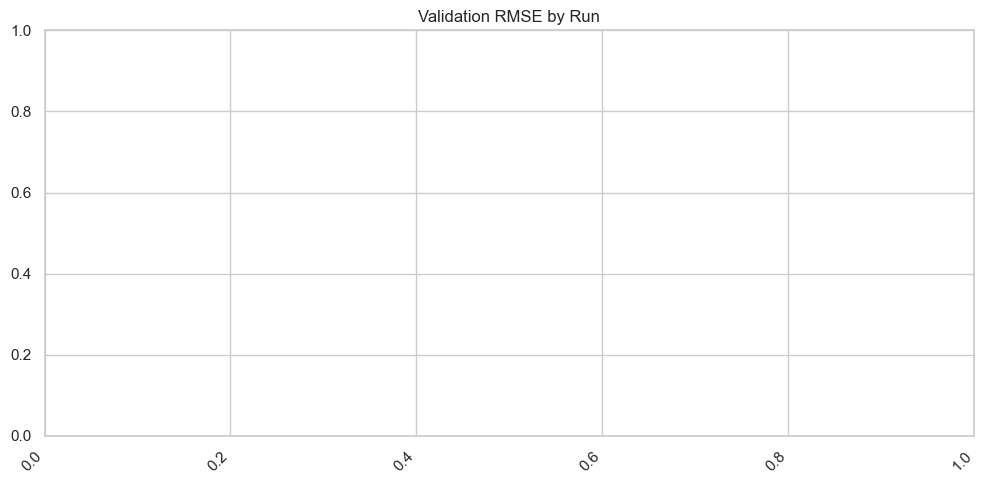

In [10]:
# Notebook cell 4: Plotting examples

# A simple barplot of val_rmse across runs, color by model_type
plt.figure(figsize=(10, 5))
plot_df = valid_runs_df.copy()
plot_df["run_id_short"] = plot_df["run_id"].apply(lambda x: x[:15] + "..." if len(x) > 15 else x)

sns.barplot(
    data=plot_df,
    x="run_id_short",
    y="val_rmse",
    hue="model_type"
)
plt.title("Validation RMSE by Run")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [11]:
# Notebook cell 5: Inspect epoch-wise training curves for a particular run
# (if we have 'epoch_metrics' in the data)

some_run_id = best_run["run_id"] if not valid_runs_df.empty else None
if some_run_id:
    # find that run in all_runs
    run_details = next((r for r in all_runs if r["run_id"] == some_run_id), None)
    
    if run_details and run_details["epoch_metrics"] is not None:
        epoch_df = run_details["epoch_metrics"].copy()
        
        # Potential columns: ['step','train_loss','val_loss','train_rmse','val_rmse','train_rank_corr','val_rank_corr', ...]
        # Let's plot train_rmse and val_rmse over epochs
        plt.figure(figsize=(8,5))
        plt.plot(epoch_df["step"], epoch_df["train_rmse"], label="Train RMSE")
        plt.plot(epoch_df["step"], epoch_df["val_rmse"], label="Val RMSE")
        plt.xlabel("Epoch")
        plt.ylabel("RMSE")
        plt.title(f"Epoch RMSE Curves for Run: {some_run_id}")
        plt.legend()
        plt.show()
    else:
        print(f"No epoch_metrics for run {some_run_id} or run not found.")
